In [71]:
import pandas as pd
import requests
import time
import os
import matplotlib.pyplot as plt
import plotly.express as px
import plotly.graph_objects as go
import numpy as np
import seaborn as sns

from sklearn.preprocessing import StandardScaler
from sklearn.cluster import DBSCAN, KMeans
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import OneHotEncoder
from sklearn.metrics import silhouette_score
from tqdm import tqdm


#### Premier dataset

In [2]:
df = pd.read_csv('Incendies.csv', sep=';', encoding='utf-8', skiprows=3)
pd.set_option('display.max_columns', None)
print(df.head(10))
print(df.shape)


   Année  Numéro Département Code INSEE      Nom de la commune  \
0   2014    6330          66      66190      Salses-le-Château   
1   2014    2369          06      06074              Lantosque   
2   2014    2546          2A      2A139                  Lecci   
3   2014       6          65      65173                Esterre   
4   2014    8243          2B      2B058                 Canari   
5   2014       7          65      65233                 Jarret   
6   2014    1997          30      30051  Branoux-les-Taillades   
7   2014    6439          66      66196                 Sorède   
8   2014    6002          2B      2B242         Poggio-Mezzana   
9   2014      56         974      97421                Salazie   

  Date de première alerte  Surface parcourue (m2)  Surface forêt (m2)  \
0     2014-01-02 14:56:00                   10000                 NaN   
1     2014-01-07 13:50:00                   48400                 NaN   
2     2014-01-09 16:14:00                      10     

In [3]:
# Basic stats
print("Number of rows : {}".format(df.shape[0]))
print()

print("Display of dataset: ")
display(df.head(10))
pd.options.display.max_columns = None 
print()

print("Basics statistics: ")
df_desc = df.describe(include="all")
display(df_desc)
print()

print("Total and percentage of missing values: ")
missing_total = df.isnull().sum().sum()
display(missing_total)
missing_percent = 100 * df.isnull().sum() / df.shape[0]
display(missing_percent[missing_percent != 0])

Number of rows : 29732

Display of dataset: 


,Année,Numéro,Département,Code INSEE,Nom de la commune,Date de première alerte,Surface parcourue (m2),Surface forêt (m2),Surface maquis garrigues (m2),Autres surfaces naturelles hors forêt (m2),Surfaces agricoles (m2),Autres surfaces (m2),Surface autres terres boisées (m2),Surfaces non boisées naturelles (m2),Surfaces non boisées artificialisées (m2),Surfaces non boisées (m2),Précision des surfaces,Type de peuplement,Nature,Décès ou bâtiments touchés,Nombre de décès,Nombre de bâtiments totalement détruits,Nombre de bâtiments partiellement détruits,Précision de la donnée
0,2014,6330,66,66190,Salses-le-Château,2014-01-02 14:56:00,10000,NaN,10000.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.0,Involontaire (particulier),NaN,NaN,NaN,NaN,NaN
1,2014,2369,06,06074,Lantosque,2014-01-07 13:50:00,48400,NaN,48400.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.0,NaN,NaN,NaN,NaN,NaN,NaN
2,2014,2546,2A,2A139,Lecci,2014-01-09 16:14:00,10,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,2014,6,65,65173,Esterre,2014-01-10 20:04:00,10000,10000.0,NaN,0.0,NaN,NaN,0.0,0.0,0.0,0.0,Estimées,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,2014,8243,2B,2B058,Canari,2014-01-11 14:00:00,100,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
5,2014,7,65,65233,Jarret,2014-01-12 16:41:00,200,0.0,NaN,200.0,NaN,NaN,200.0,0.0,0.0,0.0,Estimées,NaN,NaN,NaN,NaN,NaN,NaN,NaN
6,2014,1997,30,30051,Branoux-les-Taillades,2014-01-13 19:24:00,2500,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
7,2014,6439,66,66196,Sorède,2014-01-17 16:40:00,10000,NaN,10000.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.0,Involontaire (travaux),NaN,NaN,NaN,NaN,NaN
8,2014,6002,2B,2B242,Poggio-Mezzana,2014-01-18 14:57:00,3000,0.0,3000.0,NaN,NaN,NaN,NaN,NaN,NaN,0.0,NaN,1.0,NaN,NaN,NaN,NaN,NaN,NaN
9,2014,56,974,97421,Salazie,2014-01-21 14:08:00,3000,0.0,NaN,3000.0,NaN,NaN,3000.0,0.0,0.0,0.0,Estimées,NaN,NaN,NaN,NaN,NaN,NaN,NaN



Basics statistics: 


,Année,Numéro,Département,Code INSEE,Nom de la commune,Date de première alerte,Surface parcourue (m2),Surface forêt (m2),Surface maquis garrigues (m2),Autres surfaces naturelles hors forêt (m2),Surfaces agricoles (m2),Autres surfaces (m2),Surface autres terres boisées (m2),Surfaces non boisées naturelles (m2),Surfaces non boisées artificialisées (m2),Surfaces non boisées (m2),Précision des surfaces,Type de peuplement,Nature,Décès ou bâtiments touchés,Nombre de décès,Nombre de bâtiments totalement détruits,Nombre de bâtiments partiellement détruits,Précision de la donnée
count,29732.000000,29732.000000,29732,29732,29705,29732,2.973200e+04,2.100500e+04,8.809000e+03,1.453600e+04,4064.000000,4.048000e+03,1.055100e+04,7.620000e+03,7.422000e+03,1.167100e+04,12091,11135.000000,14111,4731,866.000000,867.000000,866.000000,813
unique,NaN,NaN,96,7740,7586,29053,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2,NaN,5,2,NaN,NaN,NaN,1
top,NaN,NaN,13,97415,Saint-Paul,2020-07-30 00:51:00,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Estimées,NaN,Malveillance,Non,NaN,NaN,NaN,Données partielles ou non valides
freq,NaN,NaN,2688,363,366,7,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,9653,NaN,4593,4690,NaN,NaN,NaN,813
mean,2018.986715,8390.076382,NaN,NaN,NaN,NaN,5.425808e+04,4.481169e+04,4.277521e+04,9.906364e+03,1529.158465,9.097792e+02,8.953332e+03,5.263809e+03,3.538426e+03,1.140125e+04,NaN,1.998383,NaN,NaN,0.003464,0.110727,0.062356,NaN
std,2.991246,6514.790521,NaN,NaN,NaN,NaN,1.115496e+06,1.225440e+06,4.436538e+05,1.234060e+05,22583.735051,3.430465e+04,9.137842e+04,1.225254e+05,4.687192e+04,1.633593e+05,NaN,1.437769,NaN,NaN,0.058789,2.353654,1.032777,NaN
min,2014.000000,1.000000,NaN,NaN,NaN,NaN,1.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,NaN,1.000000,NaN,NaN,0.000000,0.000000,0.000000,NaN
25%,2016.000000,2683.000000,NaN,NaN,NaN,NaN,1.000000e+02,0.000000e+00,2.000000e+01,0.000000e+00,0.000000,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,NaN,1.000000,NaN,NaN,0.000000,0.000000,0.000000,NaN
50%,2019.000000,7244.000000,NaN,NaN,NaN,NaN,1.000000e+03,1.500000e+02,5.000000e+02,0.000000e+00,0.000000,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,NaN,1.000000,NaN,NaN,0.000000,0.000000,0.000000,NaN
75%,2022.000000,12175.250000,NaN,NaN,NaN,NaN,1.000000e+04,3.000000e+03,7.900000e+03,3.000000e+02,0.000000,0.000000e+00,1.000000e+03,0.000000e+00,0.000000e+00,0.000000e+00,NaN,3.000000,NaN,NaN,0.000000,0.000000,0.000000,NaN



Total and percentage of missing values: 


370265

Nom de la commune                              0.090811
Surface forêt (m2)                            29.352213
Surface maquis garrigues (m2)                 70.371990
Autres surfaces naturelles hors forêt (m2)    51.109915
Surfaces agricoles (m2)                       86.331226
Autres surfaces (m2)                          86.385040
Surface autres terres boisées (m2)            64.512983
Surfaces non boisées naturelles (m2)          74.371048
Surfaces non boisées artificialisées (m2)     75.036997
Surfaces non boisées (m2)                     60.745998
Précision des surfaces                        59.333378
Type de peuplement                            62.548769
Nature                                        52.539352
Décès ou bâtiments touchés                    84.087851
Nombre de décès                               97.087313
Nombre de bâtiments totalement détruits       97.083950
Nombre de bâtiments partiellement détruits    97.087313
Précision de la donnée                        97

In [4]:
df.columns

Index(['Année', 'Numéro', 'Département', 'Code INSEE', 'Nom de la commune',
       'Date de première alerte', 'Surface parcourue (m2)',
       'Surface forêt (m2)', 'Surface maquis garrigues (m2)',
       'Autres surfaces naturelles hors forêt (m2)', 'Surfaces agricoles (m2)',
       'Autres surfaces (m2)', 'Surface autres terres boisées (m2)',
       'Surfaces non boisées naturelles (m2)',
       'Surfaces non boisées artificialisées (m2)',
       'Surfaces non boisées (m2)', 'Précision des surfaces',
       'Type de peuplement', 'Nature', 'Décès ou bâtiments touchés',
       'Nombre de décès', 'Nombre de bâtiments totalement détruits',
       'Nombre de bâtiments partiellement détruits', 'Précision de la donnée'],
      dtype='object')

In [5]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 29732 entries, 0 to 29731
Data columns (total 24 columns):
 #   Column                                      Non-Null Count  Dtype  
---  ------                                      --------------  -----  
 0   Année                                       29732 non-null  int64  
 1   Numéro                                      29732 non-null  int64  
 2   Département                                 29732 non-null  object 
 3   Code INSEE                                  29732 non-null  object 
 4   Nom de la commune                           29705 non-null  object 
 5   Date de première alerte                     29732 non-null  object 
 6   Surface parcourue (m2)                      29732 non-null  int64  
 7   Surface forêt (m2)                          21005 non-null  float64
 8   Surface maquis garrigues (m2)               8809 non-null   float64
 9   Autres surfaces naturelles hors forêt (m2)  14536 non-null  float64
 10  Surfaces a

In [6]:
print(df['Nom de la commune'].value_counts())

Nom de la commune
Saint-Paul                 366
Martigues                  217
Porto-Vecchio              162
Aix-en-Provence            156
Istres                     138
                          ... 
Parnans                      1
Crucheray                    1
Melleroy                     1
Troisfontaines-la-Ville      1
Malissard                    1
Name: count, Length: 7586, dtype: int64


In [7]:
communes = df["Nom de la commune"]
communes_uniques = communes.unique()
liste_communes = communes.unique().tolist()

print(liste_communes)

['Salses-le-Château', 'Lantosque', 'Lecci', 'Esterre', 'Canari', 'Jarret', 'Branoux-les-Taillades', 'Sorède', 'Poggio-Mezzana', 'Salazie', 'Saint-Joseph', 'Saint-Benoît', 'Saint-Jeannet', 'Bigorno', 'Venaco', 'Canet-en-Roussillon', 'Vescovato', 'Ollioules', 'Ortiporio', 'Saint-Pierre', 'Saint-Louis', 'Beaudéan', 'Salbris', 'Scata', "Espira-de-l'Agly", 'Cesseras', 'Armissan', 'Passa', 'Fleury', 'Saint-Marsal', 'Le Verdon-sur-Mer', 'Loreto-di-Casinca', 'Scolca', 'Portel-des-Corbières', 'Lézignan-Corbières', 'Corte', 'Vailhan', 'Bocognano', 'Saint-Chinian', 'Saint-Denis', "Saint-Nazaire-d'Aude", 'Fabrezan', 'Creste', 'Saint-Julien-des-Points', 'Montouliers', 'Sacoué', 'Valdeblore', 'Saint-Diéry', 'Arques', 'Ajaccio', 'Sartène', 'Calce', 'Linguizzetta', 'Valle-di-Rostino', 'Bisinchi', 'Casevecchie', 'Saint-Hippolyte', 'Oupia', 'Baixas', 'Saint-Étienne-Vallée-Française', 'Langogne', 'Conca', 'Magalas', 'Barles', 'Vialas', 'Altier', 'Ilonse', 'Beaumont-de-Lomagne', 'Saint-Privat-de-Vallongue

#### Test API Nominatim et requête

In [8]:
r = requests.get('https://nominatim.openstreetmap.org/search')
r

<Response [200]>

In [9]:

# url = "https://nominatim.openstreetmap.org/search"
# headers = {
#     "User-Agent": "MyGeocoder/1.0 (myemail@example.com)"
# }
# output_file = "coordonnees_villes.csv"
# delay = 1  # en secondes, respect de la limite Nominatim
# places = [p for p in liste_communes if pd.notna(p)]

# # Charger les données déjà géocodées si le fichier existe
# if os.path.exists(output_file):
#     existing_df = pd.read_csv(output_file)
#     done_places = set(existing_df["ville"])
#     data_list = existing_df.to_dict("records")
# else:
#     done_places = set()
#     data_list = []

# # Boucle principale avec reprise
# for place in tqdm(places, desc="Géocodage des communes"):
#     place_str = str(place).strip()
#     if place_str in done_places:
#         continue  # éviter les doublons déjà traités

#     params = {
#         "q": place_str + ", France",
#         "format": "json",
#         "limit": 1
#     }

#     try:
#         response = requests.get(url, params=params, headers=headers)
#         if response.status_code == 200:
#             data = response.json()
#             if data:
#                 lat = data[0].get("lat")
#                 lon = data[0].get("lon")
#             else:
#                 lat, lon = None, None
#         else:
#             lat, lon = None, None

#     except Exception as e:
#         print(f"Erreur pour {place_str} : {e}")
#         lat, lon = None, None

#     data_list.append({"ville": place_str, "latitude": lat, "longitude": lon})
#     done_places.add(place_str)

#     # Sauvegarde après chaque ville
#     pd.DataFrame(data_list).to_csv(output_file, index=False)

#     # Pause pour respecter la limite Nominatim
#     time.sleep(delay)

# print("\n✅ Géocodage terminé. Données enregistrées dans :", output_file)



#### Second DF

In [10]:
df2 = pd.read_csv('Incendies 2006-2013.csv', sep=';', encoding='utf-8', skiprows=6)
pd.set_option('display.max_columns', None)
df2.head(10)

,Année,Numéro,Département,Code INSEE,Nom de la commune,Date de première alerte,Surface parcourue (m2),Surface forêt (m2),Surface maquis garrigues (m2),Autres surfaces naturelles hors forêt (m2),Surfaces agricoles (m2),Autres surfaces (m2),Surface autres terres boisées (m2),Surfaces non boisées naturelles (m2),Surfaces non boisées artificialisées (m2),Surfaces non boisées (m2),Précision des surfaces,Type de peuplement,Nature,Décès ou bâtiments touchés,Nombre de décès,Nombre de bâtiments totalement détruits,Nombre de bâtiments partiellement détruits,Précision de la donnée
0,2006,8806,66,66179,Saint-Laurent-de-Cerdans,2006-01-01 12:50:00,10000,10000.0,0.0,NaN,NaN,NaN,NaN,NaN,NaN,0.0,NaN,1.0,Naturelle,NaN,NaN,NaN,NaN,NaN
1,2006,8917,66,66190,Salses-le-Château,2006-01-01 12:56:00,20000,0.0,20000.0,NaN,NaN,NaN,NaN,NaN,NaN,0.0,NaN,1.0,Involontaire (particulier),NaN,NaN,NaN,NaN,NaN
2,2006,4695,83,83028,Callas,2006-01-01 15:40:00,30,30.0,0.0,NaN,NaN,NaN,NaN,NaN,NaN,0.0,NaN,5.0,Involontaire (particulier),NaN,NaN,NaN,NaN,NaN
3,2006,8028,34,34237,Roujan,2006-01-02 18:19:00,37500,10000.0,27500.0,NaN,NaN,NaN,NaN,NaN,NaN,0.0,NaN,1.0,Malveillance,NaN,NaN,NaN,NaN,NaN
4,2006,5806,83,83050,Draguignan,2006-01-02 20:57:00,200,200.0,0.0,NaN,NaN,NaN,NaN,NaN,NaN,0.0,NaN,5.0,Involontaire (travaux),NaN,NaN,NaN,NaN,NaN
5,2006,7696,48,48152,Saint-Frézal-de-Ventalon,2006-01-03 15:31:00,250,50.0,200.0,NaN,NaN,NaN,NaN,NaN,NaN,0.0,NaN,5.0,Accidentelle,NaN,NaN,NaN,NaN,NaN
6,2006,5362,83,83049,Cuers,2006-01-04 13:15:00,400,400.0,0.0,NaN,NaN,NaN,NaN,NaN,NaN,0.0,NaN,5.0,Involontaire (particulier),NaN,NaN,NaN,NaN,NaN
7,2006,5473,06,06101,Rigaud,2006-01-04 15:54:00,2500,0.0,2500.0,NaN,NaN,NaN,NaN,NaN,NaN,0.0,NaN,1.0,NaN,NaN,NaN,NaN,NaN,NaN
8,2006,8362,06,06101,Rigaud,2006-01-05 15:24:00,500,0.0,500.0,NaN,NaN,NaN,NaN,NaN,NaN,0.0,NaN,1.0,NaN,NaN,NaN,NaN,NaN,NaN
9,2006,6943,13,13098,Saint-Mitre-les-Remparts,2006-01-05 17:06:00,10,0.0,0.0,NaN,NaN,NaN,NaN,NaN,NaN,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [11]:
communes2 = df2["Nom de la commune"]
communes_uniques2 = communes2.unique()
liste_communes2 = communes2.unique().tolist()

print(liste_communes2)

['Saint-Laurent-de-Cerdans', 'Salses-le-Château', 'Callas', 'Roujan', 'Draguignan', 'Saint-Frézal-de-Ventalon', 'Cuers', 'Rigaud', 'Saint-Mitre-les-Remparts', 'Salignac-Eyvigues', 'Saint-Paul-de-Serre', 'Évisa', 'Aubagne', 'Isola', 'Coggia', 'Propriano', 'Caychax', 'Le Collet-de-Dèze', 'Chirac', 'Bastia', "Sant'Andréa-di-Bozio", 'Solaro', 'La Roquebrussanne', 'Lézat-sur-Lèze', 'Larcat', 'Sisco', "Espira-de-l'Agly", 'Bastelica', 'Patrimonio', 'Calenzana', "Le Mas-d'Azil", 'Senconac', 'Canari', 'Rogliano', 'Vico', 'Vero', 'Ota', 'Roquefixade', 'Levie', 'Saint-Germain-de-Calberte', 'Pietraserena', 'Santo-Pietro-di-Venaco', 'Saint-Quirc', 'Bocognano', 'Coti-Chiavari', 'Vaychis', 'Malarce-sur-la-Thines', 'Vouharte', 'Les Bondons', 'Utelle', 'Salaunes', "Monacia-d'Aullène", "Cuxac-d'Aude", 'Saint-Jean-du-Gard', 'Saurat', 'Furiani', 'Mazaugues', 'Lagorce', 'Audenge', 'Cercoux', 'Laragne-Montéglin', 'Sorbo-Ocagnano', 'Urtaca', 'Besse-sur-Issole', 'Corconne', 'Borgo', 'Valleraugue', 'Levens', '

In [12]:
df2['Nom de la commune'].value_counts()

Nom de la commune
Ajaccio              209
Sartène              199
Porto-Vecchio        148
Oletta               131
Calenzana            104
                    ... 
Saint-Loubouer         1
Lacapelle-Cabanac      1
Saint-Brès             1
Flassan                1
Orincles               1
Name: count, Length: 4754, dtype: int64

#### Fusion des listes de villes sans doublon

In [13]:
fusion = list(set(liste_communes + liste_communes2))
print(fusion)

['Le Rouget-Pers', 'Cheverny', 'Montdoumerc', 'Chevenoz', 'Saint-Rambert-en-Bugey', 'Carolles', 'Cergy', 'Cancale', 'Marzan', 'Osani', 'Saint-Barthélemy', 'Javols', 'Cannes', 'Muracciole', 'Rimsdorf', 'Turquant', 'Soussans', 'Saint-Pierre-de-Manneville', 'Prinsuéjols-Malbouzon', 'Chameyrat', 'Le Muy', 'Nespouls', 'La Chapelle-Montmartin', 'Cardan', 'Saint-Joseph-de-Rivière', 'Landerneau', 'Thonac', 'Concèze', 'Vitré', 'Valprivas', "Saint-Jacques-d'Atticieux", 'Mezel', 'Visan', 'Saint-Jacques-des-Blats', 'Boissy-Maugis', 'Saint-Nizier-le-Bouchoux', 'Oradour-sur-Glane', 'Champsecret', 'Boisset', 'Clamensane', 'Galgan', 'Saint-Jean-Chambre', 'Couffé', 'Curtil-sous-Burnand', 'Couffoulens', 'Saint-Sulpice-sur-Risle', 'Laugnac', 'Poligny', 'Marsac', 'Trausse', 'Ghisonaccia', 'Mathay', 'Bauduen', 'Busque', "Portet-d'Aspet", 'Allèves', 'Appy', 'Vendeuvre-du-Poitou', 'Aubas', 'La Bâtie-Vieille', 'Clermont-Ferrand', 'Villaudric', 'Maillères', 'Labastide-sur-Bésorgues', 'Arvert', "Sainte-Cécile-d

In [14]:
print(len(fusion))

9082


#### Requête des coordonnées GPS en ne rajoutant que les nouvelles villes

In [15]:
# url = "https://nominatim.openstreetmap.org/search"
# headers = {
#     "User-Agent": "MyGeocoder/1.0 (myemail@example.com)"
# }
# output_file = "coordonnees_villes.csv"
# delay = 1  # en secondes, respect de la limite Nominatim
# places = [p for p in fusion if pd.notna(p)]

# # Charger les données déjà géocodées si le fichier existe
# if os.path.exists(output_file):
#     existing_df = pd.read_csv(output_file)
#     done_places = set(existing_df["ville"])
#     data_list = existing_df.to_dict("records")
# else:
#     done_places = set()
#     data_list = []

# # Boucle principale avec reprise
# for place in tqdm(places, desc="Géocodage des communes"):
#     place_str = str(place).strip()
#     if place_str in done_places:
#         continue  # éviter les doublons déjà traités

#     params = {
#         "q": place_str + ", France",
#         "format": "json",
#         "limit": 1
#     }

#     try:
#         response = requests.get(url, params=params, headers=headers)
#         if response.status_code == 200:
#             data = response.json()
#             if data:
#                 lat = data[0].get("lat")
#                 lon = data[0].get("lon")
#             else:
#                 lat, lon = None, None
#         else:
#             lat, lon = None, None

#     except Exception as e:
#         print(f"Erreur pour {place_str} : {e}")
#         lat, lon = None, None

#     data_list.append({"ville": place_str, "latitude": lat, "longitude": lon})
#     done_places.add(place_str)

#     # Sauvegarde après chaque ville
#     pd.DataFrame(data_list).to_csv(output_file, index=False)

#     # Pause pour respecter la limite Nominatim
#     time.sleep(delay)

# print("\n✅ Géocodage terminé. Données enregistrées dans :", output_file)

In [16]:
print(df['Nature'].value_counts())

Nature
Malveillance                  4593
Involontaire (particulier)    3656
Involontaire (travaux)        2478
Accidentelle                  2001
Naturelle                     1383
Name: count, dtype: int64


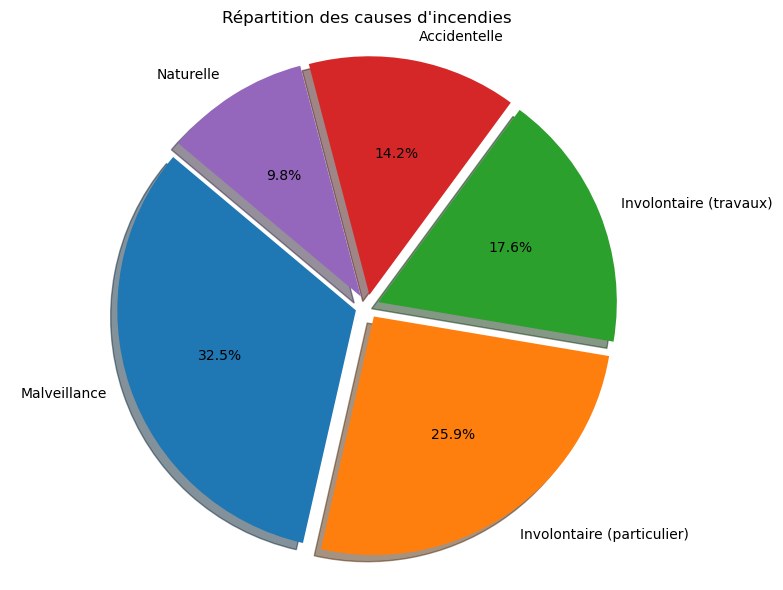

In [17]:
causes = df['Nature'].value_counts()

# Création du pie chart
plt.figure(figsize=(8, 6))
plt.pie(causes.values, labels=causes.index,
        autopct='%1.1f%%', startangle=140, shadow=True, explode=[0.05]*len(causes))

plt.title("Répartition des causes d'incendies")
plt.axis('equal')  # Assure un cercle parfait
plt.tight_layout()
plt.show()

In [18]:
coords=pd.read_csv('coordonnees_villes.csv', sep=',', encoding='utf-8')
coords.head(10)

,ville,latitude,longitude
0,Salses-le-Château,42.833380,2.918180
1,Lantosque,43.973468,7.312593
2,Lecci,41.679373,9.317798
3,Esterre,42.874901,0.006078
4,Canari,42.845933,9.331333
5,Jarret,43.082300,-0.014354
6,Branoux-les-Taillades,44.219600,3.991240
7,Sorède,42.530402,2.956454
8,Poggio-Mezzana,42.397680,9.493930
9,Salazie,-21.024383,55.543545


In [19]:
coords.rename(columns={"ville": "Nom de la commune"}, inplace=True)
coords.head(5)

,Nom de la commune,latitude,longitude
0,Salses-le-Château,42.833380,2.918180
1,Lantosque,43.973468,7.312593
2,Lecci,41.679373,9.317798
3,Esterre,42.874901,0.006078
4,Canari,42.845933,9.331333


In [20]:
coords['latitude'].isnull().sum()

6

In [21]:
coords['longitude'].isnull().sum()

6

In [22]:
coords=coords.dropna(subset=['latitude', 'longitude'])
coords.isna().sum()

Nom de la commune    0
latitude             0
longitude            0
dtype: int64

### Vérification visuelle de la pertinence des coordonnées GPS

In [23]:
fig = px.scatter_mapbox(
    coords, 
    lat="latitude", 
    lon="longitude", 
    hover_name="Nom de la commune",
    height=1000,
    zoom=5,
    mapbox_style="carto-positron")
fig.show()

#### Fusion des csv des incendies

In [24]:
df_concat = pd.concat([df, df2], ignore_index=True)

df_concat.to_csv("fusion.csv", index=False, sep=';')

df_concat.head(10)

,Année,Numéro,Département,Code INSEE,Nom de la commune,Date de première alerte,Surface parcourue (m2),Surface forêt (m2),Surface maquis garrigues (m2),Autres surfaces naturelles hors forêt (m2),Surfaces agricoles (m2),Autres surfaces (m2),Surface autres terres boisées (m2),Surfaces non boisées naturelles (m2),Surfaces non boisées artificialisées (m2),Surfaces non boisées (m2),Précision des surfaces,Type de peuplement,Nature,Décès ou bâtiments touchés,Nombre de décès,Nombre de bâtiments totalement détruits,Nombre de bâtiments partiellement détruits,Précision de la donnée
0,2014,6330,66,66190,Salses-le-Château,2014-01-02 14:56:00,10000,NaN,10000.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.0,Involontaire (particulier),NaN,NaN,NaN,NaN,NaN
1,2014,2369,06,06074,Lantosque,2014-01-07 13:50:00,48400,NaN,48400.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.0,NaN,NaN,NaN,NaN,NaN,NaN
2,2014,2546,2A,2A139,Lecci,2014-01-09 16:14:00,10,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,2014,6,65,65173,Esterre,2014-01-10 20:04:00,10000,10000.0,NaN,0.0,NaN,NaN,0.0,0.0,0.0,0.0,Estimées,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,2014,8243,2B,2B058,Canari,2014-01-11 14:00:00,100,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
5,2014,7,65,65233,Jarret,2014-01-12 16:41:00,200,0.0,NaN,200.0,NaN,NaN,200.0,0.0,0.0,0.0,Estimées,NaN,NaN,NaN,NaN,NaN,NaN,NaN
6,2014,1997,30,30051,Branoux-les-Taillades,2014-01-13 19:24:00,2500,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
7,2014,6439,66,66196,Sorède,2014-01-17 16:40:00,10000,NaN,10000.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.0,Involontaire (travaux),NaN,NaN,NaN,NaN,NaN
8,2014,6002,2B,2B242,Poggio-Mezzana,2014-01-18 14:57:00,3000,0.0,3000.0,NaN,NaN,NaN,NaN,NaN,NaN,0.0,NaN,1.0,NaN,NaN,NaN,NaN,NaN,NaN
9,2014,56,974,97421,Salazie,2014-01-21 14:08:00,3000,0.0,NaN,3000.0,NaN,NaN,3000.0,0.0,0.0,0.0,Estimées,NaN,NaN,NaN,NaN,NaN,NaN,NaN


##### Traitement des Nan

In [25]:
nb_null = df_concat['Nom de la commune'].isnull().sum()
print(nb_null)

27


In [26]:
df_concat = df_concat.dropna(subset=['Nom de la commune'])
print(df_concat['Nom de la commune'].isnull().sum())

0


In [27]:
df_merge = df_concat.merge(coords[["Nom de la commune", "latitude", "longitude"]], 
                    on="Nom de la commune", 
                    how="left")
df_merge.head(5)

,Année,Numéro,Département,Code INSEE,Nom de la commune,Date de première alerte,Surface parcourue (m2),Surface forêt (m2),Surface maquis garrigues (m2),Autres surfaces naturelles hors forêt (m2),Surfaces agricoles (m2),Autres surfaces (m2),Surface autres terres boisées (m2),Surfaces non boisées naturelles (m2),Surfaces non boisées artificialisées (m2),Surfaces non boisées (m2),Précision des surfaces,Type de peuplement,Nature,Décès ou bâtiments touchés,Nombre de décès,Nombre de bâtiments totalement détruits,Nombre de bâtiments partiellement détruits,Précision de la donnée,latitude,longitude
0,2014,6330,66,66190,Salses-le-Château,2014-01-02 14:56:00,10000,NaN,10000.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.0,Involontaire (particulier),NaN,NaN,NaN,NaN,NaN,42.833380,2.918180
1,2014,2369,06,06074,Lantosque,2014-01-07 13:50:00,48400,NaN,48400.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.0,NaN,NaN,NaN,NaN,NaN,NaN,43.973468,7.312593
2,2014,2546,2A,2A139,Lecci,2014-01-09 16:14:00,10,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,41.679373,9.317798
3,2014,6,65,65173,Esterre,2014-01-10 20:04:00,10000,10000.0,NaN,0.0,NaN,NaN,0.0,0.0,0.0,0.0,Estimées,NaN,NaN,NaN,NaN,NaN,NaN,NaN,42.874901,0.006078
4,2014,8243,2B,2B058,Canari,2014-01-11 14:00:00,100,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,42.845933,9.331333


In [28]:
# Obtenir la liste des colonnes
colonnes = df_merge.columns.tolist()

colonnes.remove("latitude")
colonnes.remove("longitude")

colonnes.insert(5, "latitude")
colonnes.insert(6, "longitude")

df_merge = df_merge[colonnes]

df_merge.head(5)

,Année,Numéro,Département,Code INSEE,Nom de la commune,latitude,longitude,Date de première alerte,Surface parcourue (m2),Surface forêt (m2),Surface maquis garrigues (m2),Autres surfaces naturelles hors forêt (m2),Surfaces agricoles (m2),Autres surfaces (m2),Surface autres terres boisées (m2),Surfaces non boisées naturelles (m2),Surfaces non boisées artificialisées (m2),Surfaces non boisées (m2),Précision des surfaces,Type de peuplement,Nature,Décès ou bâtiments touchés,Nombre de décès,Nombre de bâtiments totalement détruits,Nombre de bâtiments partiellement détruits,Précision de la donnée
0,2014,6330,66,66190,Salses-le-Château,42.833380,2.918180,2014-01-02 14:56:00,10000,NaN,10000.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.0,Involontaire (particulier),NaN,NaN,NaN,NaN,NaN
1,2014,2369,06,06074,Lantosque,43.973468,7.312593,2014-01-07 13:50:00,48400,NaN,48400.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.0,NaN,NaN,NaN,NaN,NaN,NaN
2,2014,2546,2A,2A139,Lecci,41.679373,9.317798,2014-01-09 16:14:00,10,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,2014,6,65,65173,Esterre,42.874901,0.006078,2014-01-10 20:04:00,10000,10000.0,NaN,0.0,NaN,NaN,0.0,0.0,0.0,0.0,Estimées,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,2014,8243,2B,2B058,Canari,42.845933,9.331333,2014-01-11 14:00:00,100,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


#### Test de cluster avec DBScan

In [ ]:
# 1. Grouper pour compter la fréquence d'apparition
commune_counts = df_merge.groupby(['Nom de la commune', 'latitude', 'longitude']).size().reset_index(name='frequence')

# 2. Répliquer les lignes selon la fréquence (pondération par duplication)
df_expanded = commune_counts.loc[commune_counts.index.repeat(commune_counts['frequence'])].reset_index(drop=True)

# 3. Données pour le clustering
X = df_expanded[['latitude', 'longitude']]

# 4. Standardisation
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)


In [ ]:
db = DBSCAN(eps=0.008, min_samples=20).fit(X_scaled)

df_expanded['cluster'] = db.labels_

clustered_communes = df_expanded.groupby(['Nom de la commune', 'latitude', 'longitude'])['cluster'] \
    .agg(lambda x: x.mode()[0] if not x.mode().empty else -1).reset_index()

print(np.unique(db.labels_))

[ -1   0   1   2   3   4   5   6   7   8   9  10  11  12  13  14  15  16
  17  18  19  20  21  22  23  24  25  26  27  28  29  30  31  32  33  34
  35  36  37  38  39  40  41  42  43  44  45  46  47  48  49  50  51  52
  53  54  55  56  57  58  59  60  61  62  63  64  65  66  67  68  69  70
  71  72  73  74  75  76  77  78  79  80  81  82  83  84  85  86  87  88
  89  90  91  92  93  94  95  96  97  98  99 100 101 102 103 104 105 106
 107 108 109 110 111 112 113 114 115 116 117 118 119 120 121 122 123 124
 125 126 127 128 129 130 131 132 133 134 135 136 137 138 139 140 141 142
 143 144 145 146 147 148 149 150 151 152 153 154 155 156 157 158 159 160
 161 162 163 164 165 166 167 168 169 170 171 172 173 174 175 176 177 178
 179 180 181 182 183 184 185 186 187 188 189 190 191 192 193 194 195 196
 197 198 199 200 201 202 203 204 205 206 207 208 209 210 211 212 213 214
 215 216 217 218 219 220 221 222 223 224 225 226 227 228 229 230 231 232
 233 234 235 236 237 238 239 240 241 242 243 244 24

In [31]:
fig = px.scatter_mapbox(

        clustered_communes[clustered_communes.cluster != -1],
        lat="latitude",
        lon="longitude",
        color="cluster",
        zoom=5,
        height = 1000,        mapbox_style="carto-positron"
)

fig.show()

In [68]:
df_merge.head(5)

,Année,Numéro,Département,Code INSEE,Nom de la commune,latitude,longitude,Date de première alerte,Surface parcourue (m2),Surface forêt (m2),Surface maquis garrigues (m2),Autres surfaces naturelles hors forêt (m2),Surfaces agricoles (m2),Autres surfaces (m2),Surface autres terres boisées (m2),Surfaces non boisées naturelles (m2),Surfaces non boisées artificialisées (m2),Surfaces non boisées (m2),Précision des surfaces,Type de peuplement,Nature,Décès ou bâtiments touchés,Nombre de décès,Nombre de bâtiments totalement détruits,Nombre de bâtiments partiellement détruits,Précision de la donnée
0,2014,6330,66,66190,Salses-le-Château,42.833380,2.918180,2014-01-02 14:56:00,10000,NaN,10000.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.0,Involontaire (particulier),NaN,NaN,NaN,NaN,NaN
1,2014,2369,06,06074,Lantosque,43.973468,7.312593,2014-01-07 13:50:00,48400,NaN,48400.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.0,NaN,NaN,NaN,NaN,NaN,NaN
2,2014,2546,2A,2A139,Lecci,41.679373,9.317798,2014-01-09 16:14:00,10,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,2014,6,65,65173,Esterre,42.874901,0.006078,2014-01-10 20:04:00,10000,10000.0,NaN,0.0,NaN,NaN,0.0,0.0,0.0,0.0,Estimées,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,2014,8243,2B,2B058,Canari,42.845933,9.331333,2014-01-11 14:00:00,100,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [79]:
df_kmeans = df_merge[['Nom de la commune', 'latitude', 'longitude']].dropna()
print(df_kmeans.head(5))


   Nom de la commune   latitude  longitude
0  Salses-le-Château  42.833380   2.918180
1          Lantosque  43.973468   7.312593
2              Lecci  41.679373   9.317798
3            Esterre  42.874901   0.006078
4             Canari  42.845933   9.331333


In [80]:
numeric_features = ['latitude', 'longitude']
categorical_features = ['Nom de la commune']

# 3. Préprocesseurs
numeric_transformer = StandardScaler()

categorical_transformer = Pipeline(steps=[
    ('encoder', OneHotEncoder(drop='first', handle_unknown='ignore'))
])

preprocessor = ColumnTransformer(
    transformers=[
        ('num', numeric_transformer, numeric_features),
        ('cat', categorical_transformer, categorical_features)
    ]
)

# 4. Appliquer le préprocessing
print("Preprocessing sur le train set...")
X = preprocessor.fit_transform(df_kmeans)
print("...Terminé.")
print(X[0:5, :])
print()

Preprocessing sur le train set...
...Terminé.
  (0, 0)	-0.1256907489261935
  (0, 1)	-0.28305687243401007
  (0, 7742)	1.0
  (1, 0)	0.06082271106093424
  (1, 1)	0.48782464981166856
  (1, 3736)	1.0
  (2, 0)	-0.314481346719122
  (2, 1)	0.8395839569516396
  (2, 4075)	1.0
  (3, 0)	-0.11889814041187707
  (3, 1)	-0.7939067901826088
  (3, 2480)	1.0
  (4, 0)	-0.1236371319428528
  (4, 1)	0.8419584138290322
  (4, 1283)	1.0



In [81]:
# Utilisation de la méthode Elbow pour trouver le nombre optimal de clusters

wcss =  []
for i in range (2,40):
    kmeans = KMeans(n_clusters= i, random_state = 0)
    kmeans.fit(X)
    wcss.append(kmeans.inertia_)

print(wcss)

c:\Users\joelt\anaconda3\Lib\site-packages\joblib\externals\loky\backend\context.py:136: UserWarning:

Could not find the number of physical cores for the following reason:
[WinError 2] Le fichier spécifié est introuvable
Returning the number of logical cores instead. You can silence this warning by setting LOKY_MAX_CPU_COUNT to the number of cores you want to use.

  File "c:\Users\joelt\anaconda3\Lib\site-packages\joblib\externals\loky\backend\context.py", line 257, in _count_physical_cores
    cpu_info = subprocess.run(
               ^^^^^^^^^^^^^^^
  File "c:\Users\joelt\anaconda3\Lib\subprocess.py", line 548, in run
    with Popen(*popenargs, **kwargs) as process:
         ^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "c:\Users\joelt\anaconda3\Lib\subprocess.py", line 1026, in __init__
    self._execute_child(args, executable, preexec_fn, close_fds,
  File "c:\Users\joelt\anaconda3\Lib\subprocess.py", line 1538, in _execute_child
    hp, ht, pid, tid = _winapi.CreateProcess(executable, args

[128765.54856046953, 62149.41842043826, 58288.28159828331, 55457.340759539286, 54193.81344439497, 52744.21696621169, 54761.49325832623, 52005.73443167425, 51743.56912546744, 51564.652383392844, 51232.38375561561, 51033.59257721806, 50826.90373084793, 50729.7053597978, 50371.39826749616, 50291.74100151863, 50191.82920555696, 50104.1157819982, 49942.505674649, 49388.320324174914, 49317.87502425029, 49272.420248332644, 49207.19834598041, 49127.79524744222, 48758.605271584136, 48662.156316655986, 48613.09784555902, 48561.2664936101, 48482.269066371504, 48342.376669211175, 48285.403251797645, 48151.39226708669, 48117.753152525685, 48063.64022129043, 47746.433051439504, 47675.90340581399, 47617.90842203522, 47572.21816404142]


In [82]:
# Nouvelle visusalisation de la méthode Elbow

fig = px.line(x = range(2,40), y = wcss)
fig.show()

In [ ]:
s_score = []
k = range(2, 40)
for i in k:
    kmeans = KMeans(n_clusters=i)
    kmeans.fit(X)
    s_score.append(silhouette_score(X, kmeans.predict(X)))

print(s_score)

cluster_scores = pd.DataFrame(s_score, columns=['Silhouette Score'])

fig = px.bar(data_frame=cluster_scores,
             x=k,
             y='Silhouette Score'
            )

fig.update_layout(
    yaxis_title="Silhouette Score",
    xaxis_title="# Clusters",
    title="Silhouette Score par cluster"
)

fig.show()

In [ ]:
kmeans = KMeans(n_clusters = 6, random_state=0)

df_merge['clusterKmeans'] = kmeans.fit_predict(X)

kmeans.fit(X)

In [ ]:
df_merge.head(5)

In [ ]:
fig = px.scatter_mapbox(
    df_merge,
    lat="latitude",
    lon="longitude",
    color=("clusterKmeans"),
    zoom=5,
    height=1000,
    mapbox_style="carto-positron",
    title="Clusters KMeans d'incendies en France",
    hover_data=["Nom de la commune"]
)

fig.show()